## Model predictions

### Functions and mappings

In [385]:
def create_in_memory_geochip(predicted_chip, geotransform, crs, color_coded=False):
    """
    Apply georeferencing to the predicted chip.
    
    Parameters:
        predicted_chip (numpy array): The predicted segmentation chip (e.g., binary mask).
        geotransform (tuple): A tuple containing the geotransformation information of the chip (x-coordinate of the top left corner, x and y pixel size, rotation, y-coordinate of the top left corner, and rotation).
        crs (str): Spatial Reference System (e.g., EPSG code) of the chip.
        color_coded (bool): If the chip is color coded, it has a shape [H, W, C], othersize has a shape [1, H, W]

    Return:
        A rasterio dataset that is georreferenced.
    """
    if color_coded:
        predicted_chip = np.rollaxis(predicted_chip, axis=2) # putting the bands first
        photometric = 'RGB'
    else:
        photometric = 'MINISBLACK'
        
    memfile = MemoryFile()
    dataset = memfile.open(
        driver='GTiff',
        height=predicted_chip.shape[1],
        width=predicted_chip.shape[2],
        count=predicted_chip.shape[0],  # Number of bands
        dtype=np.uint8,
        crs=crs,
        transform=geotransform,
        photometric=photometric,
    )
    
    dataset.write(predicted_chip)
    return dataset

In [387]:
def merge_georeferenced_chips(chips_list, output_path):
    """
    Merge a list of georeferenced chips into a single GeoTIFF file.

    Parameters:
        chips_generator (generator): A generator of Rasterio datasets representing the georeferenced chips.
        output_path (str): The path where the merged GeoTIFF file will be saved.

    Returns:
        None
    """
    # Merge the chips using Rasterio's merge function
    merged, merged_transform = merge(chips_list)
    
    # Calculate the number of rows and columns for the merged output
    rows, cols = merged.shape[1], merged.shape[2]

    # Update the metadata of the merged dataset
    merged_metadata = chips_list[0].meta
    merged_metadata.update({
        'height': rows,
        'width': cols,
        'transform': merged_transform
    })

    # Write the merged array to a new GeoTIFF file
    with rasterio.open(output_path, 'w', **merged_metadata) as dst:
        dst.write(merged)
        
    for chip in chips_list:
        chip.close()

### test dataset and inference

In [171]:
import timeit
from rasterio.merge import merge
import rasterio

In [62]:
model = SemanticSegmentationTask.load_from_checkpoint("/root/wildfire prediction/models/last.ckpt") ## Here get your own checkpoint

# Set the model to evaluation mode
model.eval()

SemanticSegmentationTask(
  (criterion): CrossEntropyLoss()
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassJaccardIndex): MulticlassJaccardIndex(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassJaccardIndex): MulticlassJaccardIndex(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassJaccardIndex): MulticlassJaccardIndex(),
    prefix=test_
  )
  (model): DeepLabV3Plus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_

In [409]:
IMG_SIZE = 512
BATCH_SIZE = 512
SAMPLE_SIZE = 2000

sampler = GridGeoSampler(train_imgs, size=IMG_SIZE, stride= 256)
dataloader = DataLoader(train_imgs, sampler=sampler, collate_fn=stack_samples, shuffle=False)

In [410]:
OUTPUT_DIR = '/root/wildfire prediction/output'

## color map:
##    Purple: No fire
##    Yellow: Fire

In [411]:
len(dataloader)

35

In [428]:
crs = train_imgs.crs.to_epsg()
pixel_size = train_imgs.res

4.4915764205976074e-05

In [460]:
georref_chips_list = []
color_coded=False
item_number = 18

for i, sample in enumerate(dataloader):
    if i == item_number:
        batch = sample
        image, gt_mask, bbox = sample['image'], sample['mask'], sample['bbox'][0]
        
        image = image/255. # as I'm not using a GeoDatamodule, I need to divide de images by 255 manually

        prediction = model.model.predict(image)
        prediction = torch.softmax(prediction, dim=1)
        prediction = torch.argmax(prediction, dim = 1)
        
        geotransform = from_origin(bbox.minx, bbox.maxy, pixel_size, pixel_size)
               
        georref_chips_list.append(create_in_memory_geochip(prediction, geotransform, crs, color_coded))
        
        break
        
    else:
        pass
        

['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire predicti

In [461]:
merge_georeferenced_chips(georref_chips_list, file_name)

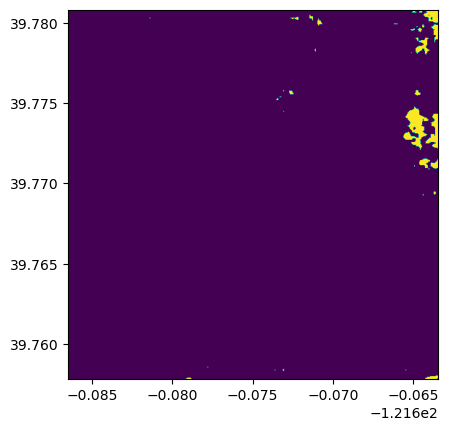

/root/wildfire prediction/output/merged_prediction.tif


In [462]:
from rasterio.plot import show

output_filepath = os.path.join(OUTPUT_DIR, 'merged_prediction.tif')
src = rasterio.open(output_filepath)
show(src.read(), transform=src.transform)
print(output_filepath)

torch.Size([4, 512, 512])
torch.Size([1, 512, 512])


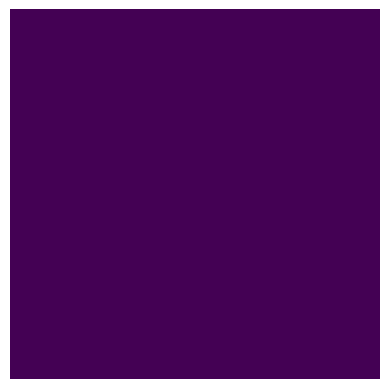

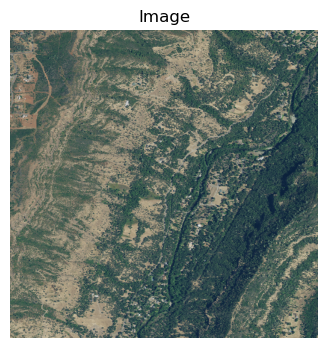

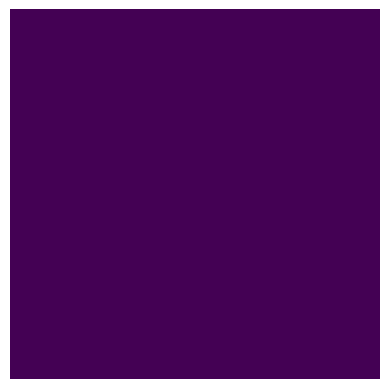

In [463]:
sample = unbind_samples(batch)[0]
image = sample["image"]
mask = sample["mask"]
print(image.shape)
print(mask.shape)
# print(image)
# print(mask)
train_imgs.plot(sample)
train_imgs.plot_mask(sample)